In [35]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

## Load dataset

In [20]:
train_dataset = MNIST('/kaggle/working', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('/kaggle/working', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

In [46]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

num_clients = 8
rounds = 20
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

In [22]:
total_train_size, total_dev_size, total_test_size

(49800, 10200, 10000)

## Network

In [23]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [40]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}
    
    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out
    
    def get_track_layers(self):
        return self.track_layers
    
    # i.e update global parameters from the averaged ones 
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data, 
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD, verb=0):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in tqdm(range(epochs), ascii=True, desc="Epoch {}".format(epoch)):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
            if verb > 0: 
                print('Epoch {} avg_loss : {}, avg_acc : {}'.format(epoch + 1, avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

# General sum Model 

Summing all the available dataset into a single dataset. 

In [41]:
def sum_model_train():
    sum_model = to_device(FederatedNet(), device)

    train_history = sum_model.fit(train_dataset, 3*10, learning_rate, batch_size, verb=1)
    #print('Loss = {}, Accuracy = {}'.format(round(train_history[-1][0], 4), round(train_history[-1][1], 4)))

    dev_loss, dev_acc = sum_model.evaluate(dev_dataset)
    print('dev_loss = {}, dev_acc = {}\n'.format(round(dev_loss, 4), round(dev_acc, 4)))
    
    return train_history

sum_model_train()

100%|██████████| 390/390 [00:23<00:00, 16.47it/s]


Epoch 0 avg_loss : 0.6092694997787476, avg_acc : 0.8249399065971375


100%|██████████| 390/390 [00:24<00:00, 16.11it/s]


Epoch 1 avg_loss : 0.1815676987171173, avg_acc : 0.9473557472229004


100%|██████████| 390/390 [00:23<00:00, 16.32it/s]


Epoch 2 avg_loss : 0.12428489327430725, avg_acc : 0.963942289352417


100%|██████████| 390/390 [00:23<00:00, 16.41it/s]


Epoch 3 avg_loss : 0.09854010492563248, avg_acc : 0.9714743494987488


100%|██████████| 390/390 [00:24<00:00, 15.92it/s]


Epoch 4 avg_loss : 0.08470989018678665, avg_acc : 0.9753004908561707


100%|██████████| 390/390 [00:24<00:00, 15.98it/s]


Epoch 5 avg_loss : 0.07523505389690399, avg_acc : 0.9778445363044739


100%|██████████| 390/390 [00:24<00:00, 15.90it/s]


Epoch 6 avg_loss : 0.06897250562906265, avg_acc : 0.9797075390815735


100%|██████████| 390/390 [00:23<00:00, 16.32it/s]


Epoch 7 avg_loss : 0.0635882243514061, avg_acc : 0.981370210647583


100%|██████████| 390/390 [00:23<00:00, 16.29it/s]


Epoch 8 avg_loss : 0.05792345851659775, avg_acc : 0.9825119972229004


100%|██████████| 390/390 [00:24<00:00, 16.20it/s]


Epoch 9 avg_loss : 0.05358882620930672, avg_acc : 0.9839743375778198


100%|██████████| 390/390 [00:24<00:00, 15.69it/s]


Epoch 10 avg_loss : 0.05070085823535919, avg_acc : 0.9849759340286255


100%|██████████| 390/390 [00:25<00:00, 15.03it/s]


Epoch 11 avg_loss : 0.0482950396835804, avg_acc : 0.9851762652397156


100%|██████████| 390/390 [00:25<00:00, 15.44it/s]


Epoch 12 avg_loss : 0.046063803136348724, avg_acc : 0.9859575033187866


100%|██████████| 390/390 [00:25<00:00, 15.42it/s]


Epoch 13 avg_loss : 0.042952582240104675, avg_acc : 0.9878805875778198


100%|██████████| 390/390 [00:24<00:00, 15.84it/s]


Epoch 14 avg_loss : 0.04087304323911667, avg_acc : 0.9872796535491943


100%|██████████| 390/390 [00:25<00:00, 15.10it/s]


Epoch 15 avg_loss : 0.038987889885902405, avg_acc : 0.9883813858032227


100%|██████████| 390/390 [00:25<00:00, 15.48it/s]


Epoch 16 avg_loss : 0.03702929988503456, avg_acc : 0.9884214997291565


100%|██████████| 390/390 [00:25<00:00, 15.27it/s]


Epoch 17 avg_loss : 0.035422712564468384, avg_acc : 0.9893629550933838


100%|██████████| 390/390 [00:25<00:00, 15.01it/s]


Epoch 18 avg_loss : 0.033590756356716156, avg_acc : 0.9896434545516968


100%|██████████| 390/390 [00:25<00:00, 15.41it/s]


Epoch 19 avg_loss : 0.03288261219859123, avg_acc : 0.9896233677864075


100%|██████████| 390/390 [00:25<00:00, 15.12it/s]


Epoch 20 avg_loss : 0.04045133665204048, avg_acc : 0.9889423251152039


100%|██████████| 390/390 [00:25<00:00, 15.18it/s]


Epoch 21 avg_loss : 0.03064712882041931, avg_acc : 0.9909855723381042


100%|██████████| 390/390 [00:25<00:00, 15.53it/s]


Epoch 22 avg_loss : 0.0291324220597744, avg_acc : 0.9908252954483032


100%|██████████| 390/390 [00:25<00:00, 15.33it/s]


Epoch 23 avg_loss : 0.02733297273516655, avg_acc : 0.9917267560958862


100%|██████████| 390/390 [00:24<00:00, 15.61it/s]


Epoch 24 avg_loss : 0.026423955336213112, avg_acc : 0.9918269515037537


100%|██████████| 390/390 [00:25<00:00, 15.54it/s]


Epoch 25 avg_loss : 0.02541182190179825, avg_acc : 0.9923678040504456


100%|██████████| 390/390 [00:26<00:00, 14.81it/s]


Epoch 26 avg_loss : 0.024825140833854675, avg_acc : 0.9921674728393555


100%|██████████| 390/390 [00:25<00:00, 15.36it/s]


Epoch 27 avg_loss : 0.025470513850450516, avg_acc : 0.9921674728393555


100%|██████████| 390/390 [00:25<00:00, 15.46it/s]


Epoch 28 avg_loss : 0.0229304451495409, avg_acc : 0.9927283525466919


100%|██████████| 390/390 [00:24<00:00, 15.88it/s]


Epoch 29 avg_loss : 0.02286849170923233, avg_acc : 0.993088960647583
Loss = 0.0229, Accuracy = 0.9931
dev_loss = 0.0511, dev_acc = 0.9861



[(0.6092694997787476, 0.8249399065971375),
 (0.1815676987171173, 0.9473557472229004),
 (0.12428489327430725, 0.963942289352417),
 (0.09854010492563248, 0.9714743494987488),
 (0.08470989018678665, 0.9753004908561707),
 (0.07523505389690399, 0.9778445363044739),
 (0.06897250562906265, 0.9797075390815735),
 (0.0635882243514061, 0.981370210647583),
 (0.05792345851659775, 0.9825119972229004),
 (0.05358882620930672, 0.9839743375778198),
 (0.05070085823535919, 0.9849759340286255),
 (0.0482950396835804, 0.9851762652397156),
 (0.046063803136348724, 0.9859575033187866),
 (0.042952582240104675, 0.9878805875778198),
 (0.04087304323911667, 0.9872796535491943),
 (0.038987889885902405, 0.9883813858032227),
 (0.03702929988503456, 0.9884214997291565),
 (0.035422712564468384, 0.9893629550933838),
 (0.033590756356716156, 0.9896434545516968),
 (0.03288261219859123, 0.9896233677864075),
 (0.04045133665204048, 0.9889423251152039),
 (0.03064712882041931, 0.9909855723381042),
 (0.0291324220597744, 0.990825295

# Client

### Cross-silo vs Cross-device FL

__Cross-Silo__ : becomes relevant when there is a limited, albeit sizeable range (for instance, anywhere between two to a
hundred) of participating entities like corporations or institutions (such as __hospitals__ and schools) that engage in learning
by training a model on their local data.


__Cross-Data__ : This configuration involves a multitude of small, geographically distributed devices, such as smartphones,
smartwatches, and edge devices. The quantity of these devices can reach up to millions, each possessing a comparatively
small amount of data and lower computational capabilities relative to the cross-silo FL paradigm.


This MNIST example is more like Cross-Data setting 

In [44]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters() # gradients 

### setup clients

In [26]:
examples_per_client = total_train_size // num_clients

client_datasets = random_split(train_dataset, [min(i + examples_per_client, 
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])

clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]
clients 

# Federated Learning

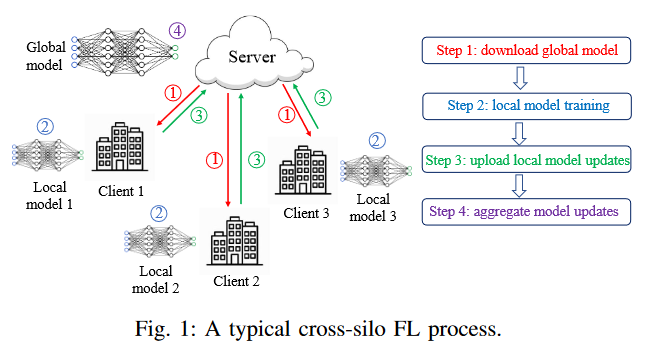

### The general Federated Learning algorithm: 

\begin{align*} 
    \min_{w\in\mathcal{R}^d} f(w) \;\;\;\;\; \text{where} \;\;\;\;\; f(w) \triangleq \frac{1}{n} \sum_{i=1}^n f_i(w)
\end{align*}

in ml, typically $f_i(w) = loss(x_i,y_i,w)$,  in this notebook $loss$ is **cross entropy**


We assume there are K clients over which the data is partitioned, with $P_k$ the set of indexes of data points on client k, with $n_k = |P_k|$. Thus, we can re-write the objective  as 
\begin{align*}
    f(w) = \sum_{k=1}^{K} \frac{n_k}{n} F_k(w)  \;\;\;\;\; \text{where} \;\;\;\;\; F_k(w) = \frac{1}{n_k} \sum_{i \in P_k} f_i(w)
\end{align*}

### FedAveraging 
$\eta$ = learning rate, 
each client $k$ computes $g_k = \nabla F_k(w_t)$ the average gradient on its local data at the current model $w_t$, and the central server aggregates these gradients and applies the update : 
\begin{align*}
    \forall k\;, w_{t+1}^k \leftarrow w_t - \eta g_k  \;\;\;\; \text{then} \;\;\;\; w_{t+1} \leftarrow \sum_{k=1}^K \frac{n_k}{n} w_{t+1}^k 
\end{align*}

That is, each client locally takes one step of gradient descent on the current model using its local data, and the server then takes a weighted average of the resulting models.

In [50]:
def FedAvg():
    # Create global model, same architecture as the ones used on the clients.
    global_net = to_device(FederatedNet(), device)

    history = []
    for i in range(rounds):
        print('Start Round {} ...'.format(i + 1))
        curr_parameters = global_net.get_parameters()
        new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])

        for client in clients:
            # client update 
            client_parameters = client.train(curr_parameters) # w^k_t+1 <- w_t - \eta g_k

            # FedAvg aggregation 
            fraction = client.get_dataset_size() / total_train_size # n_k / n 
            for layer_name in client_parameters:
                new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight'] #  sum n_k / n w^k_t+1
                new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']     # 

        global_net.apply_parameters(new_parameters) # w_t+1 <- sum n_k / n w^k_t+1

        train_loss, train_acc = global_net.evaluate(train_dataset)
        dev_loss, dev_acc = global_net.evaluate(dev_dataset)

        print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
                round(dev_loss, 4), round(dev_acc, 4)))
        
        history.append((train_loss, dev_loss))
    return history

hist = FedAvg()

Start Round 1 ...


100%|██████████| 49/49 [00:03<00:00, 16.07it/s]


client_0: Loss = 0.499, Accuracy = 0.8453


100%|██████████| 49/49 [00:03<00:00, 15.38it/s]


client_1: Loss = 0.4883, Accuracy = 0.8502


100%|██████████| 49/49 [00:03<00:00, 15.95it/s]


client_2: Loss = 0.5066, Accuracy = 0.8416


100%|██████████| 49/49 [00:03<00:00, 16.20it/s]


client_3: Loss = 0.4871, Accuracy = 0.8542


100%|██████████| 49/49 [00:03<00:00, 15.85it/s]


client_4: Loss = 0.4771, Accuracy = 0.8557


100%|██████████| 49/49 [00:03<00:00, 15.17it/s]


client_5: Loss = 0.5046, Accuracy = 0.8411


100%|██████████| 49/49 [00:03<00:00, 15.90it/s]


client_6: Loss = 0.503, Accuracy = 0.8483


100%|██████████| 49/49 [00:03<00:00, 15.20it/s]


client_7: Loss = 0.5087, Accuracy = 0.8411
After round 1, train_loss = 0.4013, dev_loss = 0.3922, dev_acc = 0.8875

Start Round 2 ...


100%|██████████| 49/49 [00:03<00:00, 16.04it/s]


client_0: Loss = 0.315, Accuracy = 0.9067


100%|██████████| 49/49 [00:03<00:00, 15.75it/s]


client_1: Loss = 0.2952, Accuracy = 0.9111


100%|██████████| 49/49 [00:03<00:00, 16.23it/s]


client_2: Loss = 0.3186, Accuracy = 0.9091


100%|██████████| 49/49 [00:03<00:00, 16.04it/s]


client_3: Loss = 0.3069, Accuracy = 0.9119


100%|██████████| 49/49 [00:03<00:00, 16.19it/s]


client_4: Loss = 0.3023, Accuracy = 0.9114


100%|██████████| 49/49 [00:03<00:00, 15.35it/s]


client_5: Loss = 0.3037, Accuracy = 0.9097


100%|██████████| 49/49 [00:03<00:00, 15.97it/s]


client_6: Loss = 0.3143, Accuracy = 0.9092


100%|██████████| 49/49 [00:03<00:00, 15.43it/s]


client_7: Loss = 0.3191, Accuracy = 0.9038
After round 2, train_loss = 0.2831, dev_loss = 0.2804, dev_acc = 0.9217

Start Round 3 ...


100%|██████████| 49/49 [00:03<00:00, 15.38it/s]


client_0: Loss = 0.2273, Accuracy = 0.9338


100%|██████████| 49/49 [00:03<00:00, 14.60it/s]


client_1: Loss = 0.2185, Accuracy = 0.9382


100%|██████████| 49/49 [00:03<00:00, 15.53it/s]


client_2: Loss = 0.2345, Accuracy = 0.9357


100%|██████████| 49/49 [00:03<00:00, 15.73it/s]


client_3: Loss = 0.2201, Accuracy = 0.9383


100%|██████████| 49/49 [00:03<00:00, 15.50it/s]


client_4: Loss = 0.2212, Accuracy = 0.9311


100%|██████████| 49/49 [00:03<00:00, 15.69it/s]


client_5: Loss = 0.2184, Accuracy = 0.9337


100%|██████████| 49/49 [00:03<00:00, 14.79it/s]


client_6: Loss = 0.2332, Accuracy = 0.9329


100%|██████████| 49/49 [00:03<00:00, 14.33it/s]


client_7: Loss = 0.2336, Accuracy = 0.9342
After round 3, train_loss = 0.2142, dev_loss = 0.2144, dev_acc = 0.9399

Start Round 4 ...


100%|██████████| 49/49 [00:03<00:00, 15.55it/s]


client_0: Loss = 0.1784, Accuracy = 0.9471


100%|██████████| 49/49 [00:03<00:00, 15.41it/s]


client_1: Loss = 0.1672, Accuracy = 0.9505


100%|██████████| 49/49 [00:03<00:00, 15.88it/s]


client_2: Loss = 0.1844, Accuracy = 0.9516


100%|██████████| 49/49 [00:03<00:00, 15.37it/s]


client_3: Loss = 0.1728, Accuracy = 0.952


100%|██████████| 49/49 [00:03<00:00, 15.74it/s]


client_4: Loss = 0.1693, Accuracy = 0.9515


100%|██████████| 49/49 [00:03<00:00, 15.83it/s]


client_5: Loss = 0.1696, Accuracy = 0.9486


100%|██████████| 49/49 [00:03<00:00, 15.62it/s]


client_6: Loss = 0.1849, Accuracy = 0.946


100%|██████████| 49/49 [00:03<00:00, 15.27it/s]


client_7: Loss = 0.1839, Accuracy = 0.9506
After round 4, train_loss = 0.1698, dev_loss = 0.1738, dev_acc = 0.9501

Start Round 5 ...


100%|██████████| 49/49 [00:03<00:00, 15.91it/s]


client_0: Loss = 0.1442, Accuracy = 0.9575


100%|██████████| 49/49 [00:03<00:00, 15.81it/s]


client_1: Loss = 0.1378, Accuracy = 0.9598


100%|██████████| 49/49 [00:03<00:00, 16.17it/s]


client_2: Loss = 0.1538, Accuracy = 0.9583


100%|██████████| 49/49 [00:03<00:00, 15.47it/s]


client_3: Loss = 0.1419, Accuracy = 0.9596


100%|██████████| 49/49 [00:03<00:00, 15.70it/s]


client_4: Loss = 0.1377, Accuracy = 0.9601


100%|██████████| 49/49 [00:03<00:00, 15.92it/s]


client_5: Loss = 0.1382, Accuracy = 0.9592


100%|██████████| 49/49 [00:03<00:00, 16.12it/s]


client_6: Loss = 0.1515, Accuracy = 0.9579


100%|██████████| 49/49 [00:03<00:00, 15.84it/s]


client_7: Loss = 0.1509, Accuracy = 0.9596
After round 5, train_loss = 0.1407, dev_loss = 0.1459, dev_acc = 0.9582

Start Round 6 ...


100%|██████████| 49/49 [00:03<00:00, 15.79it/s]


client_0: Loss = 0.1249, Accuracy = 0.9617


100%|██████████| 49/49 [00:03<00:00, 15.68it/s]


client_1: Loss = 0.1157, Accuracy = 0.967


100%|██████████| 49/49 [00:02<00:00, 16.38it/s]


client_2: Loss = 0.1326, Accuracy = 0.9637


100%|██████████| 49/49 [00:02<00:00, 17.07it/s]


client_3: Loss = 0.1236, Accuracy = 0.9653


100%|██████████| 49/49 [00:03<00:00, 16.17it/s]


client_4: Loss = 0.117, Accuracy = 0.9675


100%|██████████| 49/49 [00:03<00:00, 16.23it/s]


client_5: Loss = 0.1166, Accuracy = 0.9649


100%|██████████| 49/49 [00:03<00:00, 15.28it/s]


client_6: Loss = 0.1315, Accuracy = 0.965


100%|██████████| 49/49 [00:02<00:00, 16.80it/s]


client_7: Loss = 0.1302, Accuracy = 0.9657
After round 6, train_loss = 0.1232, dev_loss = 0.1292, dev_acc = 0.9622

Start Round 7 ...


100%|██████████| 49/49 [00:02<00:00, 16.67it/s]


client_0: Loss = 0.107, Accuracy = 0.9675


100%|██████████| 49/49 [00:03<00:00, 16.22it/s]


client_1: Loss = 0.1014, Accuracy = 0.9712


100%|██████████| 49/49 [00:02<00:00, 16.50it/s]


client_2: Loss = 0.1164, Accuracy = 0.9696


100%|██████████| 49/49 [00:02<00:00, 16.61it/s]


client_3: Loss = 0.1093, Accuracy = 0.9691


100%|██████████| 49/49 [00:03<00:00, 16.31it/s]


client_4: Loss = 0.1017, Accuracy = 0.9697


100%|██████████| 49/49 [00:03<00:00, 15.77it/s]


client_5: Loss = 0.1018, Accuracy = 0.9705


100%|██████████| 49/49 [00:03<00:00, 16.27it/s]


client_6: Loss = 0.1162, Accuracy = 0.9678


100%|██████████| 49/49 [00:03<00:00, 16.10it/s]


client_7: Loss = 0.1162, Accuracy = 0.9667
After round 7, train_loss = 0.1077, dev_loss = 0.1153, dev_acc = 0.9659

Start Round 8 ...


100%|██████████| 49/49 [00:02<00:00, 17.30it/s]


client_0: Loss = 0.0981, Accuracy = 0.9699


100%|██████████| 49/49 [00:02<00:00, 16.86it/s]


client_1: Loss = 0.0913, Accuracy = 0.9742


100%|██████████| 49/49 [00:02<00:00, 16.73it/s]


client_2: Loss = 0.1072, Accuracy = 0.9704


100%|██████████| 49/49 [00:03<00:00, 15.16it/s]


client_3: Loss = 0.0948, Accuracy = 0.9721


100%|██████████| 49/49 [00:03<00:00, 16.30it/s]


client_4: Loss = 0.0886, Accuracy = 0.9758


100%|██████████| 49/49 [00:02<00:00, 16.66it/s]


client_5: Loss = 0.0893, Accuracy = 0.9734


100%|██████████| 49/49 [00:03<00:00, 16.24it/s]


client_6: Loss = 0.1046, Accuracy = 0.9696


100%|██████████| 49/49 [00:02<00:00, 16.84it/s]


client_7: Loss = 0.1031, Accuracy = 0.9717
After round 8, train_loss = 0.0983, dev_loss = 0.1064, dev_acc = 0.9676

Start Round 9 ...


100%|██████████| 49/49 [00:02<00:00, 16.50it/s]


client_0: Loss = 0.0879, Accuracy = 0.9737


100%|██████████| 49/49 [00:02<00:00, 16.75it/s]


client_1: Loss = 0.0828, Accuracy = 0.9757


100%|██████████| 49/49 [00:03<00:00, 16.07it/s]


client_2: Loss = 0.099, Accuracy = 0.9724


100%|██████████| 49/49 [00:02<00:00, 17.17it/s]


client_3: Loss = 0.0888, Accuracy = 0.9747


100%|██████████| 49/49 [00:02<00:00, 16.45it/s]


client_4: Loss = 0.0823, Accuracy = 0.9777


100%|██████████| 49/49 [00:02<00:00, 16.98it/s]


client_5: Loss = 0.0816, Accuracy = 0.9756


100%|██████████| 49/49 [00:02<00:00, 16.48it/s]


client_6: Loss = 0.0952, Accuracy = 0.9726


100%|██████████| 49/49 [00:02<00:00, 16.64it/s]


client_7: Loss = 0.0935, Accuracy = 0.976
After round 9, train_loss = 0.0895, dev_loss = 0.0985, dev_acc = 0.9705

Start Round 10 ...


100%|██████████| 49/49 [00:02<00:00, 16.66it/s]


client_0: Loss = 0.0816, Accuracy = 0.9761


100%|██████████| 49/49 [00:03<00:00, 15.71it/s]


client_1: Loss = 0.0741, Accuracy = 0.9797


100%|██████████| 49/49 [00:02<00:00, 16.67it/s]


client_2: Loss = 0.0891, Accuracy = 0.9756


100%|██████████| 49/49 [00:03<00:00, 16.14it/s]


client_3: Loss = 0.0837, Accuracy = 0.9754


100%|██████████| 49/49 [00:02<00:00, 16.36it/s]


client_4: Loss = 0.0758, Accuracy = 0.9775


100%|██████████| 49/49 [00:03<00:00, 15.83it/s]


client_5: Loss = 0.074, Accuracy = 0.9774


100%|██████████| 49/49 [00:02<00:00, 16.67it/s]


client_6: Loss = 0.0879, Accuracy = 0.9766


100%|██████████| 49/49 [00:02<00:00, 16.40it/s]


client_7: Loss = 0.0866, Accuracy = 0.9775
After round 10, train_loss = 0.0824, dev_loss = 0.0924, dev_acc = 0.9718

Start Round 11 ...


100%|██████████| 49/49 [00:03<00:00, 16.33it/s]


client_0: Loss = 0.0773, Accuracy = 0.977


100%|██████████| 49/49 [00:03<00:00, 15.78it/s]


client_1: Loss = 0.0679, Accuracy = 0.9812


100%|██████████| 49/49 [00:02<00:00, 16.57it/s]


client_2: Loss = 0.0854, Accuracy = 0.9743


100%|██████████| 49/49 [00:03<00:00, 16.27it/s]


client_3: Loss = 0.0763, Accuracy = 0.9773


100%|██████████| 49/49 [00:02<00:00, 16.48it/s]


client_4: Loss = 0.0694, Accuracy = 0.9799


100%|██████████| 49/49 [00:02<00:00, 17.59it/s]


client_5: Loss = 0.0697, Accuracy = 0.9771


100%|██████████| 49/49 [00:03<00:00, 15.78it/s]


client_6: Loss = 0.0823, Accuracy = 0.9762


100%|██████████| 49/49 [00:02<00:00, 16.87it/s]


client_7: Loss = 0.081, Accuracy = 0.9782
After round 11, train_loss = 0.0771, dev_loss = 0.0881, dev_acc = 0.973

Start Round 12 ...


100%|██████████| 49/49 [00:03<00:00, 15.91it/s]


client_0: Loss = 0.0706, Accuracy = 0.979


100%|██████████| 49/49 [00:02<00:00, 17.22it/s]


client_1: Loss = 0.0635, Accuracy = 0.9829


100%|██████████| 49/49 [00:03<00:00, 16.08it/s]


client_2: Loss = 0.0802, Accuracy = 0.9777


100%|██████████| 49/49 [00:03<00:00, 16.20it/s]


client_3: Loss = 0.0722, Accuracy = 0.9803


100%|██████████| 49/49 [00:02<00:00, 16.49it/s]


client_4: Loss = 0.0665, Accuracy = 0.982


100%|██████████| 49/49 [00:03<00:00, 16.13it/s]


client_5: Loss = 0.064, Accuracy = 0.98


100%|██████████| 49/49 [00:02<00:00, 16.50it/s]


client_6: Loss = 0.0767, Accuracy = 0.9775


100%|██████████| 49/49 [00:02<00:00, 17.05it/s]


client_7: Loss = 0.0741, Accuracy = 0.9791
After round 12, train_loss = 0.0744, dev_loss = 0.0858, dev_acc = 0.9734

Start Round 13 ...


100%|██████████| 49/49 [00:02<00:00, 17.44it/s]


client_0: Loss = 0.0661, Accuracy = 0.9801


100%|██████████| 49/49 [00:02<00:00, 16.41it/s]


client_1: Loss = 0.0593, Accuracy = 0.985


100%|██████████| 49/49 [00:02<00:00, 16.63it/s]


client_2: Loss = 0.0776, Accuracy = 0.9759


100%|██████████| 49/49 [00:02<00:00, 17.63it/s]


client_3: Loss = 0.0687, Accuracy = 0.9795


100%|██████████| 49/49 [00:02<00:00, 18.01it/s]


client_4: Loss = 0.062, Accuracy = 0.9812


100%|██████████| 49/49 [00:03<00:00, 15.92it/s]


client_5: Loss = 0.0598, Accuracy = 0.9818


100%|██████████| 49/49 [00:02<00:00, 17.26it/s]


client_6: Loss = 0.0727, Accuracy = 0.9793


100%|██████████| 49/49 [00:02<00:00, 16.59it/s]


client_7: Loss = 0.0713, Accuracy = 0.9802
After round 13, train_loss = 0.0689, dev_loss = 0.0806, dev_acc = 0.9752

Start Round 14 ...


100%|██████████| 49/49 [00:02<00:00, 17.08it/s]


client_0: Loss = 0.0627, Accuracy = 0.9807


100%|██████████| 49/49 [00:03<00:00, 15.93it/s]


client_1: Loss = 0.0547, Accuracy = 0.9857


100%|██████████| 49/49 [00:02<00:00, 16.83it/s]


client_2: Loss = 0.0727, Accuracy = 0.9792


100%|██████████| 49/49 [00:02<00:00, 16.58it/s]


client_3: Loss = 0.0636, Accuracy = 0.9819


100%|██████████| 49/49 [00:02<00:00, 16.48it/s]


client_4: Loss = 0.0569, Accuracy = 0.9833


100%|██████████| 49/49 [00:02<00:00, 16.54it/s]


client_5: Loss = 0.0568, Accuracy = 0.983


100%|██████████| 49/49 [00:03<00:00, 16.31it/s]


client_6: Loss = 0.0692, Accuracy = 0.9786


100%|██████████| 49/49 [00:03<00:00, 15.46it/s]


client_7: Loss = 0.0688, Accuracy = 0.9812
After round 14, train_loss = 0.0656, dev_loss = 0.0781, dev_acc = 0.9753

Start Round 15 ...


100%|██████████| 49/49 [00:02<00:00, 17.07it/s]


client_0: Loss = 0.061, Accuracy = 0.9814


100%|██████████| 49/49 [00:02<00:00, 17.17it/s]


client_1: Loss = 0.0527, Accuracy = 0.9855


100%|██████████| 49/49 [00:02<00:00, 17.69it/s]


client_2: Loss = 0.0695, Accuracy = 0.9791


100%|██████████| 49/49 [00:02<00:00, 17.41it/s]


client_3: Loss = 0.0609, Accuracy = 0.9816


100%|██████████| 49/49 [00:02<00:00, 16.70it/s]


client_4: Loss = 0.0557, Accuracy = 0.9817


100%|██████████| 49/49 [00:02<00:00, 16.98it/s]


client_5: Loss = 0.0521, Accuracy = 0.9846


100%|██████████| 49/49 [00:03<00:00, 16.26it/s]


client_6: Loss = 0.0663, Accuracy = 0.9797


100%|██████████| 49/49 [00:02<00:00, 17.70it/s]


client_7: Loss = 0.0636, Accuracy = 0.9826
After round 15, train_loss = 0.0624, dev_loss = 0.0752, dev_acc = 0.9758

Start Round 16 ...


100%|██████████| 49/49 [00:02<00:00, 18.35it/s]


client_0: Loss = 0.0572, Accuracy = 0.983


100%|██████████| 49/49 [00:02<00:00, 17.07it/s]


client_1: Loss = 0.05, Accuracy = 0.9864


100%|██████████| 49/49 [00:03<00:00, 16.01it/s]


client_2: Loss = 0.0677, Accuracy = 0.9803


100%|██████████| 49/49 [00:02<00:00, 17.96it/s]


client_3: Loss = 0.0582, Accuracy = 0.9833


100%|██████████| 49/49 [00:03<00:00, 16.31it/s]


client_4: Loss = 0.0505, Accuracy = 0.9839


100%|██████████| 49/49 [00:02<00:00, 17.08it/s]


client_5: Loss = 0.0499, Accuracy = 0.9852


100%|██████████| 49/49 [00:02<00:00, 16.51it/s]


client_6: Loss = 0.062, Accuracy = 0.9835


100%|██████████| 49/49 [00:02<00:00, 17.06it/s]


client_7: Loss = 0.0611, Accuracy = 0.983
After round 16, train_loss = 0.0598, dev_loss = 0.0732, dev_acc = 0.9769

Start Round 17 ...


100%|██████████| 49/49 [00:02<00:00, 16.44it/s]


client_0: Loss = 0.0556, Accuracy = 0.9832


100%|██████████| 49/49 [00:02<00:00, 16.77it/s]


client_1: Loss = 0.0481, Accuracy = 0.9872


100%|██████████| 49/49 [00:02<00:00, 16.34it/s]


client_2: Loss = 0.0646, Accuracy = 0.9807


100%|██████████| 49/49 [00:02<00:00, 16.35it/s]


client_3: Loss = 0.0557, Accuracy = 0.9836


100%|██████████| 49/49 [00:02<00:00, 16.72it/s]


client_4: Loss = 0.0499, Accuracy = 0.9857


100%|██████████| 49/49 [00:03<00:00, 16.26it/s]


client_5: Loss = 0.0475, Accuracy = 0.9873


100%|██████████| 49/49 [00:02<00:00, 16.70it/s]


client_6: Loss = 0.0601, Accuracy = 0.9829


100%|██████████| 49/49 [00:03<00:00, 16.15it/s]


client_7: Loss = 0.0576, Accuracy = 0.984
After round 17, train_loss = 0.0579, dev_loss = 0.0719, dev_acc = 0.9764

Start Round 18 ...


100%|██████████| 49/49 [00:03<00:00, 16.22it/s]


client_0: Loss = 0.0532, Accuracy = 0.9842


100%|██████████| 49/49 [00:03<00:00, 15.88it/s]


client_1: Loss = 0.0457, Accuracy = 0.9864


100%|██████████| 49/49 [00:02<00:00, 16.59it/s]


client_2: Loss = 0.0627, Accuracy = 0.9812


100%|██████████| 49/49 [00:02<00:00, 16.82it/s]


client_3: Loss = 0.0557, Accuracy = 0.9846


100%|██████████| 49/49 [00:02<00:00, 17.16it/s]


client_4: Loss = 0.0463, Accuracy = 0.9863


100%|██████████| 49/49 [00:02<00:00, 17.30it/s]


client_5: Loss = 0.0443, Accuracy = 0.9871


100%|██████████| 49/49 [00:02<00:00, 17.83it/s]


client_6: Loss = 0.0592, Accuracy = 0.9829


100%|██████████| 49/49 [00:02<00:00, 17.14it/s]


client_7: Loss = 0.0553, Accuracy = 0.986
After round 18, train_loss = 0.0556, dev_loss = 0.0695, dev_acc = 0.9777

Start Round 19 ...


100%|██████████| 49/49 [00:02<00:00, 16.73it/s]


client_0: Loss = 0.0525, Accuracy = 0.9838


100%|██████████| 49/49 [00:02<00:00, 17.04it/s]


client_1: Loss = 0.0428, Accuracy = 0.9871


100%|██████████| 49/49 [00:02<00:00, 16.86it/s]


client_2: Loss = 0.0594, Accuracy = 0.9815


100%|██████████| 49/49 [00:02<00:00, 16.46it/s]


client_3: Loss = 0.0516, Accuracy = 0.9856


100%|██████████| 49/49 [00:02<00:00, 16.41it/s]


client_4: Loss = 0.0452, Accuracy = 0.9866


100%|██████████| 49/49 [00:02<00:00, 16.72it/s]


client_5: Loss = 0.0439, Accuracy = 0.9866


100%|██████████| 49/49 [00:02<00:00, 16.98it/s]


client_6: Loss = 0.0563, Accuracy = 0.9824


100%|██████████| 49/49 [00:02<00:00, 16.80it/s]


client_7: Loss = 0.0542, Accuracy = 0.985
After round 19, train_loss = 0.0545, dev_loss = 0.0686, dev_acc = 0.9783

Start Round 20 ...


100%|██████████| 49/49 [00:02<00:00, 16.49it/s]


client_0: Loss = 0.0492, Accuracy = 0.9839


100%|██████████| 49/49 [00:02<00:00, 16.46it/s]


client_1: Loss = 0.0418, Accuracy = 0.9883


100%|██████████| 49/49 [00:03<00:00, 16.01it/s]


client_2: Loss = 0.0579, Accuracy = 0.9837


100%|██████████| 49/49 [00:02<00:00, 16.53it/s]


client_3: Loss = 0.0506, Accuracy = 0.9854


100%|██████████| 49/49 [00:02<00:00, 16.58it/s]


client_4: Loss = 0.0437, Accuracy = 0.9874


100%|██████████| 49/49 [00:02<00:00, 16.86it/s]


client_5: Loss = 0.0415, Accuracy = 0.9877


100%|██████████| 49/49 [00:02<00:00, 17.22it/s]


client_6: Loss = 0.054, Accuracy = 0.9843


100%|██████████| 49/49 [00:02<00:00, 16.98it/s]


client_7: Loss = 0.0516, Accuracy = 0.9851
After round 20, train_loss = 0.0521, dev_loss = 0.0674, dev_acc = 0.9782



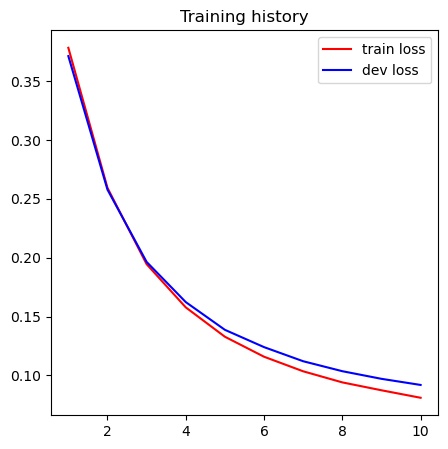

In [28]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

# $\delta$-accuracy loss 

Lets, respectively denote the accuracy's $\mathcal{V}_{sum}, \mathcal{V}_{fed}$. Let $\delta \in \R_+$, if 

\begin{align}
    | \mathcal{V}_{fed} - \mathcal{V}_{sum} | < \delta
\end{align} 

we say the fl alg has $\delta$-accuracy loss.

$
\mathcal{V}_{M_{sum}} = 0.9861 \;\;\;\;\; \mathcal{V}_{M_{fed}} = 0.9782
$ 


and 


$  | \mathcal{V}_{fed} - \mathcal{V}_{sum} |  = | 0.9782 - 0.9861 | =  0.0079 < 0.01 $


Thus our FL alg has 0.01-accuracy loss


# Biblio 

> [Communication-Efficient Learning of Deep Networks from Decentralized Data](https://arxiv.org/abs/1602.05629)    
> [Federated Learning, concept and applications](https://arxiv.org/abs/1902.04885)  
> [Cross-Silo Federated Learning: Challenges and Opportunities](https://arxiv.org/abs/2206.12949)   
